### Experiment: Formulation

**Question**: Which option is better?
- A 2D data formulation (`channels` * `samples`)
- A topological 3D formulation (`x` * `y` * `samples`) that positions the channels similar to their physical location

**Hypothesis**: The topological 3D formulation should have more inherent information regarding the relative location of each electrode, meaning that inter-channel similarities should be easier to extract. A topological 3D formulation should therefore be better at extracting features with regard to physical location.

**Result**:

#### Part 1: Investigation

In [4]:
import numpy as np
import pandas as pd
import mne
from pathlib import Path
import matplotlib.pyplot as plt

##### Show electrode montage layout

Extracting parameters from /mnt/d/thesis/sat1/eeg4/MD3-0021.vhdr...
Setting channel info structure...


/tmp/ipykernel_985/2444045899.py:4: RuntimeWarning: The unit for channel(s) A1, A2 has changed from V to NA.
  raw.set_channel_types(
/tmp/ipykernel_985/2444045899.py:8: RuntimeWarning: Not setting positions of 2 misc channels found in montage:
['A1', 'A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage("standard_1020")  # Standard 10-20 electrode montage


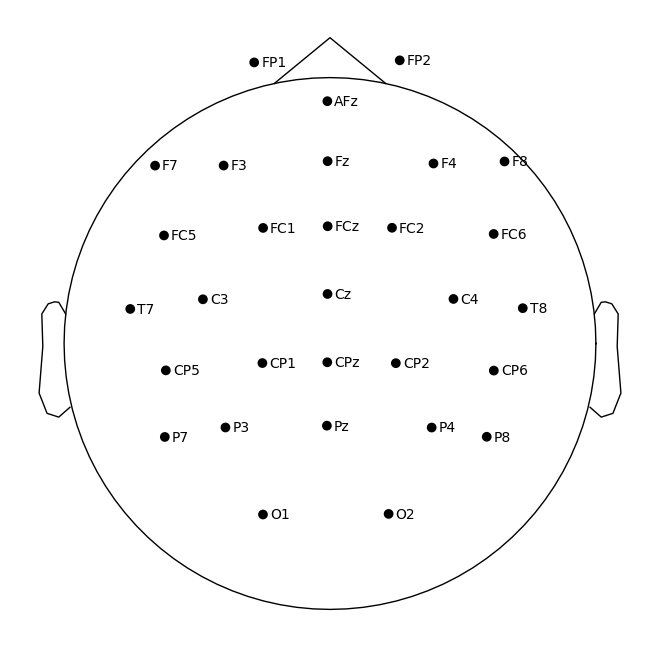

In [10]:
raw = mne.io.read_raw_brainvision(
    Path("/mnt/d/thesis/sat1/eeg4/MD3-0021.vhdr"), preload=False
)
raw.set_channel_types(
    {"EOGh": "eog", "EOGv": "eog", "A1": "misc", "A2": "misc"}
)  # Declare type to avoid confusion with EEG channels
raw.rename_channels({"FP1": "Fp1", "FP2": "Fp2"})  # Naming convention
raw.set_montage("standard_1020")  # Standard 10-20 electrode montage
raw.rename_channels({"Fp1": "FP1", "Fp2": "FP2"})

montage = raw.get_montage()
plot = montage.plot()

##### Replicate layout
Method of creating a sparse array retaining physical nearness adapted from Liu, Yang (2021)

In [12]:
CHANNELS_2D = np.array(
    [
        ["NA", "Fp1", "NA", "Fp2", "NA"],
        ["NA", "NA", "AFz", "NA", "NA"],
        ["F7", "F3", "Fz", "F4", "F8"],
        ["FC5", "FC1", "FCz", "FC2", "FC6"],
        ["T7", "C3", "Cz", "C4", "T8"],
        ["CP5", "CP1", "CPz", "CP2", "CP6"],
        ["P7", "P3", "Pz", "P4", "P8"],
        ["NA", "O1", "NA", "O2", "NA"],
    ],
    dtype=str,
)
print(pd.DataFrame(CHANNELS_2D))

     0    1    2    3    4
0   NA  Fp1   NA  Fp2   NA
1   NA   NA  AFz   NA   NA
2   F7   F3   Fz   F4   F8
3  FC5  FC1  FCz  FC2  FC6
4   T7   C3   Cz   C4   T8
5  CP5  CP1  CPz  CP2  CP6
6   P7   P3   Pz   P4   P8
7   NA   O1   NA   O2   NA


#### Part 2: Experiment

In [1]:
%load_ext autoreload
%autoreload 2
from shared.training import split_data_on_participants, train_and_evaluate, k_fold_cross_validate, get_compile_kwargs
from shared.normalization import *
from shared.models import SAT1Base, SAT1Topological, SAT1TopologicalConv
from shared.utilities import CHANNELS_2D, print_results
import tensorflow as tf
import gc
from pathlib import Path
import xarray as xr
%env TF_FORCE_GPU_ALLOW_GROWTH=true
%env TF_GPU_ALLOCATOR=cuda_malloc_async

2023-10-17 17:22:59.266534: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 17:23:00.329324: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


env: TF_FORCE_GPU_ALLOW_GROWTH=true
env: TF_GPU_ALLOCATOR=cuda_malloc_async


In [2]:
data_path = Path("data/sat1/split_stage_data.nc")
data = xr.load_dataset(data_path)

logs_path = Path("logs/exp_formulation/")

height, width = CHANNELS_2D.shape

##### Base model, no topological formulation

In [8]:
tf.keras.backend.clear_session()
model = SAT1Base(len(data.channels), len(data.samples), len(data.labels))
model.compile(**get_compile_kwargs())
train_kwargs = {
    "logs_path": Path("logs/exp_formulation/"),
    "additional_info": {"formulation": "base"},
    "additional_name": f"formulation-base",
}
results = k_fold_cross_validate(
    data, model, 5, normalization_fn=norm_dummy, train_kwargs=train_kwargs
)
print_results(results)
del model
gc.collect()

Fold 1: test fold: ['0009' '0017' '0001' '0024' '0012']
Epoch 1/20


2023-10-17 16:56:02.302792: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-17 16:56:03.404609: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-17 16:56:03.747115: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fcc5f7eaa00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-17 16:56:03.747150: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-10-17 16:56:03.753422: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-17 16:56:03.863922: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

997/997 [==============================] - 18s 14ms/step - loss: 3.7066 - accuracy: 0.7296 - val_loss: 0.5758 - val_accuracy: 0.7928
Epoch 2/20
997/997 [==============================] - 14s 14ms/step - loss: 2.8105 - accuracy: 0.7980 - val_loss: 0.5475 - val_accuracy: 0.7995
Epoch 3/20
997/997 [==============================] - 14s 14ms/step - loss: 2.4854 - accuracy: 0.8171 - val_loss: 0.5191 - val_accuracy: 0.8091
Epoch 4/20
997/997 [==============================] - 14s 14ms/step - loss: 2.2796 - accuracy: 0.8363 - val_loss: 0.4910 - val_accuracy: 0.8137
Epoch 5/20
997/997 [==============================] - 14s 14ms/step - loss: 2.1011 - accuracy: 0.8462 - val_loss: 0.5169 - val_accuracy: 0.8046
Epoch 6/20
997/997 [==============================] - 14s 14ms/step - loss: 1.9350 - accuracy: 0.8553 - val_loss: 0.4922 - val_accuracy: 0.8179
Epoch 7/20
997/997 [==============================] - 14s 14ms/step - loss: 1.7803 - accuracy: 0.8679 - val_loss: 0.4895 - val_accuracy: 0.8174
Epo

645

##### Topological model without topological convolution

In [9]:
tf.keras.backend.clear_session()
model = SAT1Topological(width, height, len(data.samples), len(data.labels))
model.compile(**get_compile_kwargs())
train_kwargs = {
    "logs_path": Path("logs/exp_formulation/"),
    "additional_info": {"formulation": "topological-noconv"},
    "additional_name": f"formulation-topological-noconv",
}
results = k_fold_cross_validate(
    data,
    model,
    5,
    normalization_fn=norm_dummy,
    gen_kwargs={"shape_topological": True},
    train_kwargs=train_kwargs,
)
print_results(results)
del model
gc.collect()

Fold 1: test fold: ['0009' '0017' '0001' '0024' '0012']
Epoch 1/20
997/997 [==============================] - 19s 17ms/step - loss: 3.6646 - accuracy: 0.7340 - val_loss: 0.6077 - val_accuracy: 0.7692
Epoch 2/20
997/997 [==============================] - 17s 16ms/step - loss: 2.6927 - accuracy: 0.8040 - val_loss: 0.5134 - val_accuracy: 0.8024
Epoch 3/20
997/997 [==============================] - 17s 17ms/step - loss: 2.4319 - accuracy: 0.8224 - val_loss: 0.4653 - val_accuracy: 0.8319
Epoch 4/20
997/997 [==============================] - 17s 17ms/step - loss: 2.2068 - accuracy: 0.8405 - val_loss: 0.4949 - val_accuracy: 0.8152
Epoch 5/20
997/997 [==============================] - 17s 17ms/step - loss: 2.0113 - accuracy: 0.8551 - val_loss: 0.5085 - val_accuracy: 0.8095
Epoch 6/20
997/997 [==============================] - 17s 16ms/step - loss: 1.8462 - accuracy: 0.8640 - val_loss: 0.4842 - val_accuracy: 0.8238
Epoch 7/20
997/997 [==============================] - 17s 16ms/step - loss: 1.68

2744

##### Topological model with topological convolution

In [3]:
tf.keras.backend.clear_session()
model = SAT1TopologicalConv(width, height, len(data.samples), len(data.labels))
model.compile(**get_compile_kwargs())
train_kwargs = {
    "logs_path": Path("logs/exp_formulation/"),
    "additional_info": {"formulation": "topological"},
    "additional_name": f"formulation-topological",
}
results = k_fold_cross_validate(
    data,
    model,
    5,
    normalization_fn=norm_dummy,
    gen_kwargs={"shape_topological": True},
    train_kwargs=train_kwargs,
)
print_results(results)
del model
gc.collect()

2023-10-17 17:23:05.968681: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-17 17:23:06.044509: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-17 17:23:06.044785: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-17 17:23:06.051908: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-17 17:23:06.052267: I tensorflow/compile

Fold 1: test fold: ['0009' '0017' '0001' '0024' '0012']
Epoch 1/20


2023-10-17 17:23:09.656351: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-17 17:23:10.474917: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-17 17:23:10.715827: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1986d7e970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-17 17:23:10.715866: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-10-17 17:23:10.721957: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-17 17:23:10.834461: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

997/997 [==============================] - 18s 14ms/step - loss: 3.4087 - accuracy: 0.7555 - val_loss: 0.5852 - val_accuracy: 0.7889
Epoch 2/20
997/997 [==============================] - 14s 14ms/step - loss: 2.4579 - accuracy: 0.8241 - val_loss: 0.5089 - val_accuracy: 0.8110
Epoch 3/20
997/997 [==============================] - 14s 13ms/step - loss: 2.2182 - accuracy: 0.8393 - val_loss: 0.5445 - val_accuracy: 0.8108
Epoch 4/20
997/997 [==============================] - 13s 13ms/step - loss: 2.0554 - accuracy: 0.8498 - val_loss: 0.5208 - val_accuracy: 0.8041
Epoch 5/20
997/997 [==============================] - 13s 13ms/step - loss: 1.9381 - accuracy: 0.8583 - val_loss: 0.4649 - val_accuracy: 0.8305
Epoch 6/20
997/997 [==============================] - 14s 13ms/step - loss: 1.7596 - accuracy: 0.8709 - val_loss: 0.4631 - val_accuracy: 0.8307
Epoch 7/20
997/997 [==============================] - 14s 13ms/step - loss: 1.6561 - accuracy: 0.8778 - val_loss: 0.4823 - val_accuracy: 0.8393
Epo

521

View results in TensorBoard

In [6]:
# View results in Tensorboard
! tensorboard --logdir logs/exp_formulation/

2023-10-13 14:05:48.740655: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.13.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C
